In [65]:
# Handling the imports
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob, os, tqdm
import numpy as np
import tensorflow as tf
%matplotlib inline

/Users/Janjua/Desktop/Projects/Kaggle_Competitions_Solutions/Severstal/severstal-steel-defect-detection/train_images/0002cc93b.jpg


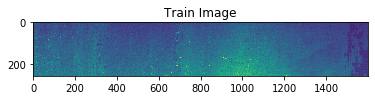

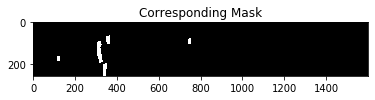

In [66]:
# read data
BASEPATH = '/Users/Janjua/Desktop/Projects/Kaggle_Competitions_Solutions/Severstal/severstal-steel-defect-detection/'
train_meta = pd.read_csv(BASEPATH + 'train.csv')
meta_dict = {}

class DataLoader:
    def __init__(self):
        pass

    def prepare_data_dictionary(self):
        for ix in range(len(train_meta)):
            data_container = []
            image_id = BASEPATH + 'train_images/' + train_meta['ImageId'][ix]
            class_id = train_meta['ClassId'][ix]
            encoded_pixels = train_meta['EncodedPixels'][ix]
            data_container.append((class_id, encoded_pixels))
            meta_dict[image_id] = data_container
    
    def rle2mask(self, rle, imgshape):
        width = imgshape[0]
        height = imgshape[1]
        mask = np.zeros(width*height).astype(np.uint8)
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]
        current_position = 0
        for index, start in enumerate(starts):
            mask[int(start):int(start+lengths[index])] = 1
            current_position += lengths[index]
        return np.flipud(np.rot90(mask.reshape(height,width), k=1))

dl = DataLoader()
dl.prepare_data_dictionary()
img_path = list(meta_dict.keys())[0]
print(img_path)
id_, rle = meta_dict[img_path][0]
img = cv2.imread(img_path, 0)
mask = dl.rle2mask(rle, img.shape)

plt.imshow(img)
plt.title('Train Image')
plt.show()
plt.imshow(mask, cmap='gray')
plt.title('Corresponding Mask')
plt.show()

In [ ]:
img_path = list(meta_dict.keys())
X = []
y = []
lab = []
for path in img_path:
    img = cv2.imread(path, 0)
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=-1)
    id_, rle = meta_dict[path][0]
    mask = dl.rle2mask(rle, img.shape)
    X.append(img)
    y.append(mask)
    lab.append(id_)

In [ ]:
print(X[0])
X = np.array(X)
y = np.array(y)
lab = np.array(lab)
print('Image Shape: ', X.shape)
print('Mask Shape: ', y.shape)
print('Class Labels: ', lab.shape)

In [ ]:
# save the arrays to save time
np.save(BASEPATH + 'X.npy', X)
np.save(BASEPATH + 'y.npy', y)
np.save(BASEPATH + 'lbl.npy', lab)
print("Done Saving at: {}".format(BASEPATH))

In [ ]:
y = y.reshape((-1, 256, 1600, 1))
print("Reshaped y: ", y.shape)
print('X shape: ', X.shape)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.flatten(y_true)
    y_pred_f = tf.flatten(y_pred)
    intersection = tf.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.sum(y_true_f) + tf.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred) + dice_loss(y_true, y_pred))

In [ ]:
def make_unet(X_, training):
    input_layer = X_ / 127.5 - 1
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=8, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_1")
    bn1 = tf.layers.batch_normalization(conv1, training=training, name="bn_1")
    pool1 = tf.layers.max_pooling2d(bn1, (2, 2), strides=(2, 2), name="pool_1")
    conv2 = tf.layers.conv2d(inputs=pool1, filters=16, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_2")
    bn2 = tf.layers.batch_normalization(conv2, training=training, name="bn_2")
    pool2 = tf.layers.max_pooling2d(bn2, (2, 2), strides=(2, 2), name="pool_2")
    conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_3")
    bn3 = tf.layers.batch_normalization(conv3, training=training, name="bn_3")
    pool3 = tf.layers.max_pooling2d(bn3, (2, 2), strides=(2, 2), name="pool_3")
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_4")
    bn4 = tf.layers.batch_normalization(conv4, training=training, name="bn_4")
    pool4 = tf.layers.max_pooling2d(bn4, (2, 2), strides=(2, 2), name="pool_4")
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_5")
    bn5 = tf.layers.batch_normalization(conv5, training=training, name="bn_5")
    up_conv6 = tf.layers.conv2d_transpose(bn5, filters=64, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_6")
    concat6 = tf.concat([up_conv6, conv4], axis=-1, name="concat_6")
    conv6 = tf.layers.conv2d(inputs=concat6, filters=32, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_6") 
    bn6 = tf.layers.batch_normalization(conv6, training=training, name="bn_6")
    up_conv7 = tf.layers.conv2d_transpose(bn6, filters=32, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_7")
    concat7 = tf.concat([up_conv7,conv3], axis=-1, name="concat_7")
    conv7 = tf.layers.conv2d(inputs=concat7, filters=32, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_7")
    bn7 = tf.layers.batch_normalization(conv7, training=training, name="bn_7")
    up_conv8 = tf.layers.conv2d_transpose(bn7, filters=16, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_8")
    concat8 = tf.concat([up_conv8, conv2], axis=-1, name="concat_8")
    conv8 = tf.layers.conv2d(inputs=concat8, filters=32, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_8")
    bn8 = tf.layers.batch_normalization(conv8, training=training, name="bn_8")
    up_conv9 = tf.layers.conv2d_transpose(bn8, filters=8, kernel_size=2, strides=2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="upconv_9")
    concat9 = tf.concat([up_conv9, conv1], axis=-1, name="concat_9")
    conv9 = tf.layers.conv2d(inputs=concat9, filters=32, kernel_size=[5, 5],padding="same",activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1), name="conv_layer_9")
    bn9 = tf.layers.batch_normalization(conv9, training=training, name="bn_9")
    out = tf.layers.conv2d(bn9, 1, (1, 1), name='final', activation=tf.nn.sigmoid, padding='same')
    return out

In [ ]:
tf.reset_default_graph()
nrofClasses = 4
X_inp = tf.placeholder(tf.float32, shape=[None, 256, 1600, 1], name="image")
Y_inp = tf.placeholder(tf.float32, shape=[None, 256, 1600, 1], name="mask")
lbl = tf.placeholder(tf.float32, shape=[None, nrofClasses], name='labels')
isTraining = tf.placeholder(tf.bool, name="iftraining")
global_step = tf.Variable(0, trainable=False, name='global_step')

In [ ]:
def next_batch(num, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def build_network(input_images, mask_labels):
    logits = make_unet(input_images, isTraining)
    loss = bce_dice_loss(mask_labels, logits)
    return loss

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 100
def train(x_train, x_val, y_train, y_val):
    loss = build_network(X_inp, Y_inp)
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step=global_step)
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(1, NUM_EPOCHS+1):
        batch_images, batch_labels = next_batch(BATCH_SIZE, x_train, y_train)
        _, train_iou = sess.run([train_op, loss], feed_dict={X_inp: batch_images, Y_inp: batch_labels, isTraining: True})
        print('Step: {} Loss: {}'.format(epoch, train_iou))
        if epoch % 100 == 0:
            val_iou = sess.run([loss], feed_dict={X_inp: x_val, Y_inp: y_val, isTraining: False})
            print("")
            print("Step: {} Loss: {}".format(epoch, val_iou[0]))
            save_path = saver.save(sess, "model/model-epoch{}.ckpt".format(epoch))
            print("Model saved for epoch # {}".format(epoch))
            print("")

In [ ]:
from sklearn.model_selection import train_test_split
print(X.shape, y.shape, lab.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_val: ", y_val.shape)

In [ ]:
train(X_train, X_val, y_train, y_val)